In [1]:
import os
import sys
import numpy as np
import librosa
from math import ceil
import torch
from torch import nn, optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
from fractions import Fraction
from torch.utils.data import DataLoader, TensorDataset
import pickle
from time import time
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import random
from math import ceil
from scipy.signal import find_peaks, windows, convolve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MEL_DIM=80
HIDDEN_DIM=64
DIC={
    0:[0, 0, 0, 0], 1:[0, 0, 0, 1], 2:[0, 0, 1, 0], 3:[0, 0, 1, 1],
    4:[0, 1, 0, 0], 5:[0, 1, 0, 1], 6:[0, 1, 1, 0], 7:[0, 1, 1, 1],
    8:[1, 0, 0, 0], 9:[1, 0, 0, 1], 10:[1, 0, 1, 0], 11:[1, 0, 1, 1],
    12:[1, 1, 0, 0], 13:[1, 1, 0, 1], 14:[1, 1, 1, 0], 15:[1, 1, 1, 1]
}
OUT_DIM=len(DIC)

In [2]:
def music_mel(y,sr,mel_dim=80):
    hop_length = ceil(sr / (22050/220))  # 计算hop_length
    # 提取音频特征
    spectrogram1 = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=mel_dim,hop_length=hop_length,n_fft=512)
    spectrogram2 = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=mel_dim,hop_length=hop_length,n_fft=1024)
    spectrogram3 = librosa.feature.melspectrogram(y=y, sr=sr,n_mels=mel_dim,hop_length=hop_length,n_fft=2048)
    log_spectrogram1 = Normalization(librosa.power_to_db(spectrogram1))
    log_spectrogram2 = Normalization(librosa.power_to_db(spectrogram1))
    log_spectrogram3 = Normalization(librosa.power_to_db(spectrogram1))
    return np.stack((log_spectrogram1,log_spectrogram2,log_spectrogram3),axis=2)

    
def Normalization(datas):
    Min = np.min(datas)
    Max = np.max(datas)
    return (datas-Min)/(Max-Min)


def get_F1score(pred,y_true,y,imshow=False,text=None):
    y_true=y_true.cpu().numpy()
    pred_sig=torch.sigmoid(pred).detach().cpu().numpy()
    pred_sig_mean=pred_sig.mean().item()
    
    # 创建一个与 y_true 同长度的数组，初始值为0
    y_pred = np.zeros_like(y_true)
    y_pred_= np.zeros_like(y_true)
    #获取预测值下标
    threshold=pred_sig_mean*y
    window = windows.hamming(5)
    smoothed_pred = convolve(pred_sig, window / window.sum(), mode='same')
    y_pred_indices,_=find_peaks(smoothed_pred, height=0*threshold,distance=3,prominence=threshold*0.5)
    # 标记预测为正的索引位置
    for idx in y_pred_indices:
        y_pred_[idx] = 1
        y_pred[max(0, idx-2):min(len(y_pred), idx+3)] = 1  # 设置索引及其前后各两个位置为1
    
    # 真正例（True Positives, TP）
    tp = np.sum((y_true == 1) & (y_pred == 1))
    # 假正例（False Positives, FP）
    fp = np.sum((y_true == 0) & (y_pred_== 1))
    # 假负例（False Negatives, FN）
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # 精确度
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # 召回率
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # F1分数
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    if imshow:
        plt.figure(figsize=(50,3))
        tre_line = threshold
        plt.axhline(y=tre_line, color='y', linestyle='--')
        plt.plot(smoothed_pred[:2500])
        plt.title(text)
#         plt.text(200, 0.65, 'pred:- -', color='g', ha='right', va='bottom',size=35)
#         plt.text(500, 0.65, 'label:- -', color='r', ha='right', va='bottom',size=35)
        for i,label in enumerate(y_true[:2500]):
            if label==1:
                plt.axvline(x=i, color='red', linestyle='-', linewidth=1,ymin=0.3, ymax=1)

        for i in y_pred_indices:
            if i < 2500:
                plt.axvline(x=i, color='green', linestyle='-', linewidth=1,ymin=0, ymax=0.7)
        plt.show()
    
    return f1,recall,precision



In [3]:
music_data=[]
labels_data=[]
data_paths=[]
data_len=100
data_batch=0

for root,dirs,files in os.walk('1'):
    for file in files:
        sys.stdout.write(f'\r{len(labels_data)}/{data_len}    ')
        if '.npy' in file:
            labels=np.load(root+'\\'+file)
            data_path=root+'\\'+file.split('[]')[0]
            data_paths.append(data_path)
            y, sr = librosa.load(root+'\\'+file.split('[]')[0])
            music=music_mel(y,sr,mel_dim=MEL_DIM).transpose(2,1,0)
            music_data.append(music)
            zero_array = np.zeros((music.shape[1]-labels.shape[0]))
            labels=np.append(labels,zero_array, axis=0)
            labels_data.append(labels)
        if len(music_data)>=data_len:
            combined = list(zip(music_data,labels_data,data_paths))
            random.shuffle(combined)
            music_data,labels_data,data_paths=zip(*combined)
            music_data=list(music_data)
            labels_data=list(labels_data)
            data_paths=list(data_paths)
            # 使用pickle将数据存储到文件
            data_batch+=1
            with open(f'train data/music_data{data_batch}.pkl', 'wb') as file:
                pickle.dump(music_data[:80], file)
            with open(f'train data/labels_data{data_batch}.pkl', 'wb') as file:
                pickle.dump(labels_data[:80], file)
                
            with open(f'train data/valid_music_data.pkl', 'wb') as file:
                pickle.dump(music_data[80:90], file)
            with open(f'train data/valid_labels_data.pkl', 'wb') as file:
                pickle.dump(labels_data[80:90], file)

            with open(f'train data/test_music_data.pkl', 'wb') as file:
                pickle.dump(music_data[90:], file)
            with open(f'train data/test_labels_data.pkl', 'wb') as file:
                pickle.dump(labels_data[90:], file)
            music_data=[]
            labels_data=[]
            break
    if len(music_data)>=data_len:
        break
for i in enumerate(data_paths):
    print(i)


15/100    (0, '0\\stream\\dan 4\\0\\Sawawa - Satori Trisis.ogg')
(1, '0\\stream\\vertex beta\\0\\audio.ogg')
(2, "0\\stream\\A Reyvateil's Curse\\0\\A Reyvateil's Curse 1.10.ogg")
(3, "0\\stream\\Heaven's Fall(2)\\0\\audio 1.200x (pitch raised).ogg")
(4, '0\\stream\\Finality\\0\\Finality 1.05.ogg')
(5, '0\\stream\\Legacy of kings\\0\\1700896776.ogg')
(6, '0\\stream\\_song_31170\\0\\1686154047.ogg')
(7, '0\\stream\\_song_22556\\0\\1618665159.ogg')
(8, "0\\stream\\A Reyvateil's Curse\\0\\1640487838.ogg")
(9, "0\\stream\\A Reyvateil's Curse\\0\\A Reyvateil's Curse_1.1_P.ogg")
(10, '0\\stream\\X.U\\0\\WC5VLg==_ETIA.ogg')
(11, '0\\stream\\Malody 4K Extra Dan v2-Stream (Sample)\\0\\Say A Vengeance12597.2973.ogg')
(12, '0\\stream\\dan 4\\0\\Kinoshita feat Otomachi Una Kagamine Rin - Positive Dance Time.ogg')
(13, '0\\stream\\dan 4\\0\\Sawawa - Satori Trisis.ogg')
(14, '0\\stream\\Shi Kong (Nightcore Remix)\\0\\Jing Dier - Shi Kong (Nightcore Remix).ogg')
(15, '0\\stream\\Merry Christmas Mr.La

In [3]:
## 构建模型类：MugGenModel_T判断音频的时间步上是否出现音符


class MugGenModel_T(nn.Module):
    def __init__(self):
        super(MugGenModel_T, self).__init__()
        self.train_loss=[0]
        self.test_loss=[0]
        self.train_F1=[]
        self.test_F1=[]
        self.train_Recall=[]
        self.test_Recall=[]
        self.train_Precision=[]
        self.test_Precision=[]

        self.relu=nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5,3))
        self.pool0 = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,3))
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=120, kernel_size=(5,1))
        self.fc0 = nn.Linear(960, 512)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, Input):
        batch_size,_,seq_len,_ = Input.size()

        '''
        IN SHAPE:(BATCH,CHANNEL,SEQ,FEATURES)
        IN(BATCH,3,50,80)->CONV0->(BATCH,10,25,78)-POOL0->(BATCH,10,1,26)->CONV1->(BATCH,20,1,24)->POOL1->(BATCH,20,1,8)
        TRANSPOSE & RESIZE->(BATCH,1,20*8)->LINEAR0(BATCH_SIZE,1,256)->LINEAR1(BATCH_SIZE,1,128)->LINEAR2(BATCH_SIZE,1)
        ->OUT(BATCH_SIZE,2)
        '''
        conv_out0 = self.conv0(Input)
        conv_out0 = self.dropout(self.pool0(self.relu(conv_out0)))
        
        conv_out1 = self.conv1(conv_out0)
        conv_out1 = self.dropout(self.pool1(self.relu(conv_out1)))
        
        conv_out1 = self.relu(self.conv2(conv_out1))

        conv_out1 = conv_out1.transpose(1,2).contiguous()
        
        conv_out1 = conv_out1.reshape(batch_size,1,-1)
        
        
        liner_out0=self.fc0(conv_out1)
        liner_out1=self.fc1(liner_out0)
        output = self.fc2(liner_out1)
        

        return output.flatten()#,hidden#torch.sigmoid()
    

In [ ]:
## 3. 创建模型实例、定义损失函数、定义优化器
model =  MugGenModel_T().to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01)
criterion = nn.BCEWithLogitsLoss()

In [23]:
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
# }, 'model/model_and_optimizer.pth')

# checkpoint = torch.load('model/T/81 best model_T .pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [49]:
# for param_group in optimizer.param_groups:
#             param_group['lr'] = 0.001  # 手动设置新的学习率

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

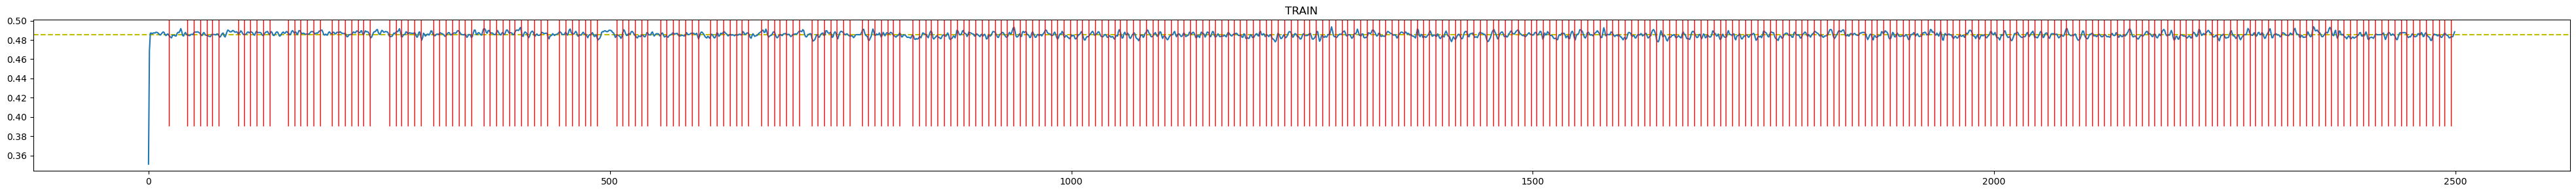


KeyboardInterrupt



In [7]:
train_label=[]
train_music=[]
test_label=[]
test_music=[]
train_F1=[]
test_F1=[]
F_temp=[]
R_temp=[]
P_temp=[]
train_data_num=1
train_loss_temp=[]

model.train()

with open(f'train data/valid_music_data.pkl', 'rb') as file:
    test_music = pickle.load(file)
with open(f'train data/valid_labels_data.pkl', 'rb') as file:
    test_label = pickle.load(file)


for epoch in tqdm(range(800)):
    if (epoch+1)%5==0:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f'model/T/{epoch} model_T .pth')
    if epoch>2:#存储在测试集上最佳的模型
        if model.test_F1[-1]>=max(model.test_F1[:-1]):
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f'model/T/{epoch} best model_T .pth')    
    
    if epoch%10==0:# and epoch>10:
        imshow=True
        
#     if epoch+1%30==0 :#and epoch+1<100:
#         for param_group in optimizer.param_groups:
#             param_group['lr'] *= 0.5  # 手动设置新的学习率
        
    while os.path.exists(f'train data/music_data{train_data_num}.pkl'):
#         if train_data_num>1:
#              break
        with open(f'train data/music_data{train_data_num}.pkl', 'rb') as file:
            music_data = pickle.load(file)#[:10]
        with open(f'train data/labels_data{train_data_num}.pkl', 'rb') as file:
            labels_data = pickle.load(file)#[:10]
        combined = list(zip(music_data, labels_data))
        random.shuffle(combined)
        music_data,labels_data=zip(*combined)
        music_data=list(music_data)
        labels_data=list(labels_data)
        train_data_num+=1 #用于选取文件夹中的数据--不将文件分开存储会极大程度的占用内存
        

        for j in tqdm(range(len(labels_data))):
            label_tmp=np.trim_zeros(labels_data[j])
            begin_pos=len(labels_data[j])-len(np.trim_zeros(labels_data[j], 'f'))
            for k in range(6,len(label_tmp)-7):
                train_label.append(label_tmp[k])
                train_music.append(music_data[j][:,begin_pos+(k-6):begin_pos+(k+7),:])
                if len(train_music)>=4096:
                    train_label=torch.tensor(np.array(train_label)).long().to(device).reshape(-1)
                    train_label=(train_label>0).int().float().flatten()
                    train_music=torch.tensor(np.array(train_music), dtype=torch.float32).to(device)
                    
                    optimizer.zero_grad()

                    output = model(train_music)
                    #计算精确度，召回率和F1-Score
                    F1,recall,precision=get_F1score(output,train_label,1,imshow=imshow,text='TRAIN')
                    imshow=False
                    F_temp.append(F1)
                    R_temp.append(recall)
                    P_temp.append(precision)
                    loss = criterion(output,train_label)
                    loss.backward()
                    optimizer.step()
                    
                    train_loss_temp.append(loss.item())
                    train_label=[]
                    train_music=[]
    R_temp=sum(R_temp)/len(R_temp)
    P_temp=sum(P_temp)/len(P_temp)
    model.train_F1.append(sum(F_temp)/len(F_temp))
    model.train_Recall.append(R_temp)
    model.train_Precision.append(P_temp)
    model.train_loss.append(sum(train_loss_temp)/len(train_loss_temp))
    print('epoch',epoch,',train_loss:',model.train_loss[-1],'|train loss variation:',model.train_loss[-1]-model.train_loss[-2])
    print(f'train_recall:{model.train_Recall[-1]}   train_precision:{model.train_Precision[-1]}  F1-Score={model.train_F1[-1]}')
    R_temp=[]
    P_temp=[]
    F_temp=[]
    
    

    if epoch%10==0:
        imshow=True

    test_R_temp=[]
    test_P_temp=[]
    test_F1_temp=[]
    test_loss_temp=[]
    for j in range(int(len(test_label))):
        test_label_temp=[]
        test_music_temp=[]
        for k in range(6,len(test_label[j])-7):
            test_label_temp.append(test_label[j][k])
            test_music_temp.append(test_music[j][:,k-6:(k+7),:])
            if len(test_label_temp)>4096 or k==len(test_label[j])-7:
                test_label_temp=torch.tensor(np.array(test_label_temp)).long().to(device).reshape(-1)
                test_label_temp=(test_label_temp>0).int().float()#.flatten()
                test_music_temp=torch.tensor(np.array(test_music_temp), dtype=torch.float32).to(device)
                with torch.no_grad():
                    output = model(test_music_temp)
                    loss=criterion(output,test_label_temp)
                    test_loss_temp.append(loss.item())
                    #计算精确度，召回率和F1-Score
                    F1,recall,precision=get_F1score(output,test_label_temp,1,imshow=imshow,text='TEST')
                    imshow=False
                    test_R_temp.append(recall)
                    test_P_temp.append(precision)
                    test_F1_temp.append(F1)
                    test_label_temp=[]
                    test_music_temp=[]
    test_R_temp=sum(test_R_temp)/(len(test_R_temp)+1e-8)
    test_P_temp=sum(test_P_temp)/(len(test_P_temp)+1e-8)
    model.test_loss.append(sum(test_loss_temp)/len(test_loss_temp))
    model.test_Recall.append(test_R_temp)
    model.test_Precision.append(test_P_temp)
    model.test_F1.append(sum(test_F1_temp)/len(test_F1_temp))
    print('test_loss:',model.test_loss[-1],'|test loss variation:',model.test_loss[-1]-model.test_loss[-2])
    print(f'test_recall:{model.test_Recall[-1]}   test_precision:{model.test_Precision[-1]}  F1-Score={model.test_F1[-1]}')
    print('-------------------------------------------------------------------------------------------------------')
    
    train_data_num=1
    train_loss_temp=[]
    train_label=[]
    train_music=[]
    test_label_temp=[]
    test_music_temp=[]

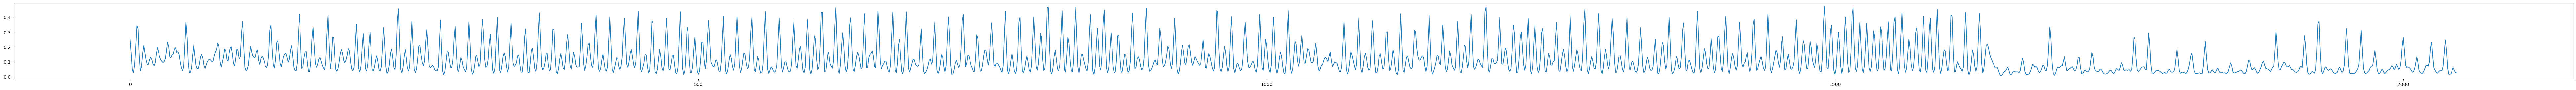

In [12]:
from scipy.signal import find_peaks
window = windows.hamming(5)
smoothed_signal = convolve(torch.sigmoid(output).cpu().detach().numpy(), window / window.sum(), mode='same')
plt.figure(figsize=(100,3))
plt.plot(smoothed_signal)

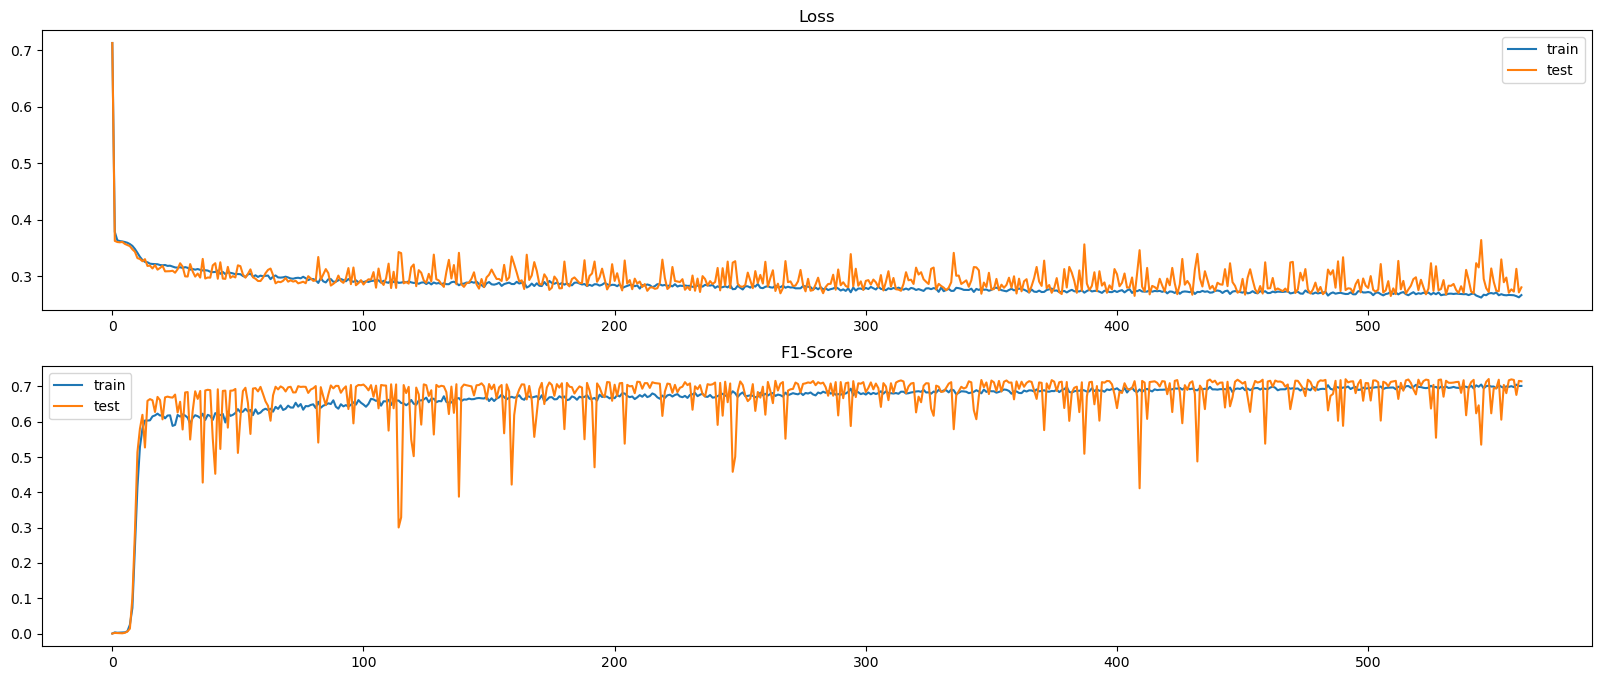

In [14]:
plt.figure(figsize=(20,8))

plt.subplot(2,1,1)
plt.plot(model.train_loss[1:],label='train')
plt.plot(model.test_loss[1:],label='test')
plt.title('Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(model.train_F1[0:],label='train')
plt.plot(model.test_F1[0:],label='test')
plt.title('F1-Score')
plt.legend()

plt.show()

In [27]:
##验证用
test_R_temp=[]
test_P_temp=[]
test_loss_temp=[]
testF1_temp=[]
modelF1=[]
resF1=[]

with open(f'train data/valid_music_data.pkl', 'rb') as file:
    test_music = pickle.load(file)
with open(f'train data/valid_labels_data.pkl', 'rb') as file:
    test_label = pickle.load(file)
model.eval()


# checkpoint = torch.load(f'model/T2/499 model_T .pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for i in tqdm(range(20)):
    for j in range(int(len(test_label))):
        #imshow=True
        test_label_temp=[]
        test_music_temp=[]
        for k in range(6,len(test_label[j])-7):
            test_label_temp.append(test_label[j][k])
            test_music_temp.append(test_music[j][:,k-6:(k+7),:])
            if len(test_label_temp)>2048 or k==len(test_label[j])-7:
                test_label_temp=torch.tensor(np.array(test_label_temp)).long().to(device).reshape(-1)
                test_label_temp=(test_label_temp>0).int().float()#.flatten()
                test_music_temp=torch.tensor(np.array(test_music_temp), dtype=torch.float32).to(device)
                with torch.no_grad():
                    output = model(test_music_temp)
                    loss=criterion(output,test_label_temp)
                    test_loss_temp.append(loss.item())
                    #计算精确度，召回率和F1-Score
                    F1,recall,precision=get_F1score(output,test_label_temp,0.1*i,imshow=imshow,text='TEST')
                    imshow=False
                    test_R_temp.append(recall)
                    test_P_temp.append(precision)
                    
                    testF1_temp.append(F1)
                    test_label_temp=[]
                    test_music_temp=[]

    Recall=sum(test_R_temp)/len(test_R_temp)
    Precision=sum(test_P_temp)/len(test_P_temp)
    F1=sum(testF1_temp)/len(testF1_temp)
    resF1.append((Recall,Precision,F1))
    test_R_temp=[]
    test_P_temp=[]
    testF1_temp=[]
#modelF1.append([resF1])
# print(Recall,Precision,(Recall,Precision,2*Recall*Precision/(Recall+Precision+1e-8)))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

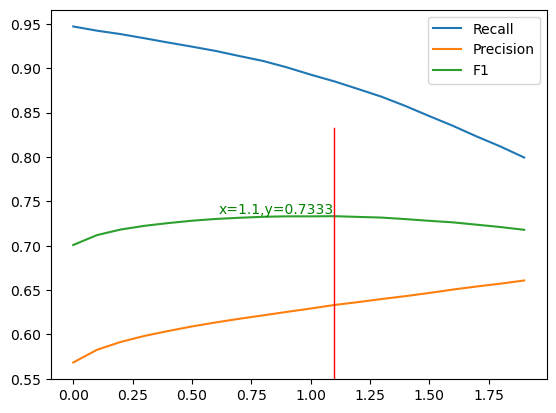

In [28]:
for i in tqdm(range(1)):
    r0=lambda x:x[0]
    r1=lambda x:x[1]
    r2=lambda x:x[2]
    plt.plot([i*0.1 for i in range(20)],[r0(i) for i in resF1],label='Recall')
    plt.plot([i*0.1 for i in range(20)],[r1(i) for i in resF1],label='Precision')
    plt.plot([i*0.1 for i in range(20)],[r2(i) for i in resF1],label='F1')

    y=max([r2(i) for i in resF1])
    x=[r2(i) for i in resF1].index(y)*0.1
    plt.text(x,y, f'x={round(x,2)},y={round(y,4)}', color='g', ha='right', va='bottom',size=10)
    plt.axvline(x=x, color='red', linestyle='-', linewidth=1,ymin=0, ymax=0.68)
    plt.legend()
    plt.show()